# AFRICAN INSTITUTE FOR MATHEMATICAL SCIENCES
## (AIMS RWANDA, KIGALI)

---

**Name:** Vincent ONDENG  
**Course:** BIG DATA ANALYTICS WITH PYTHON
---

# Introduction
The goal of this exercise is to analyze user mobility patterns using a large dataset of call detail records (CDRs) and location data. The analysis involves preprocessing the data, deriving meaningful metrics about user mobility, and exploring relationships between these metrics to gain insights. The last part of the exercise looks at the correlation between average gyration and mean and the average location.
## Objectives
Some of the operations we are going to perform are:


*   Load a sample of the dataset which countains 19700 files
*   Sample 1.5 million unique users to explore a few relatiotionship
* Generate summary statistics for these users.
* Explore the relationship between average unique locations per user and the average radius of gyration
* Calculate the correlation between average unique locations and average radius of gyration
* Create a plot to visualize the relationship between avergage unique location and the average radius of gyration



## Setting up the Environment

The tools used in this exercise include PySpark, which provides distributed data processing capabilities through SparkSession and functions like `col`, `to_date`, and `countDistinct` for efficient transformations and aggregations. Libraries like Pandas and NumPy enable data manipulation and numerical computations, while Seaborn and Matplotlib are used for creating visualizations to explore relationships in the data. Additional utilities like random and Path help with sampling and file management.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, to_timestamp, rand, countDistinct
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from pathlib import Path
import sys

## Setting up the Working Directory and Global variables

In [2]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

## TASK 1: PRE-PROCESSING THE DATA USING SPARK
The `preprocess_cdrs_using_spark` function performs essential data preprocessing tasks to transform raw Call Detail Records (CDR) into a structured format suitable for analysis. It leverages Spark's distributed computing capabilities to handle large datasets efficiently.

Initial operations, such as droping unwanted columns or removing observations with null values such as location or cell id happen here.

In [3]:
def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='yyyyMMddHHmmss',
                                debug_mode=True, loc_file=None, save_to_csv=False):
    """
    In this function, we perfom some basic preprocessing such as below:
    1. rename columns
    2. change some data types
    3. Add location details
    Eventually, we will sample the data to use for our analysis
    :param data_folder:
    :param output_csv_for_sample_users:
    :return:
    """

    spark = SparkSession.builder \
        .appName("CDR Preprocessing") \
        .master("local[2]") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.memory", "6g") \
        .config("spark.sql.shuffle.partitions", "16") \
        .getOrCreate()

    # read data with spark
    df = spark.read.option("header", True).csv(file_or_folder)

    # Renaming the last column to "cellID"
    df = df.withColumnRenamed("last calling cellid", "cellId")

    # repartition to speed up
    df = df.repartition(16)

    # Using spark sample function when debug mode is True
    if debug_mode:
        df = df.sample(withReplacement=False, fraction=0.5)

    # Drop the "call duration column"
    df = df.drop("call duration")

    # Renaming columns
    df = df.withColumnRenamed("cdr type", "cdrType").withColumnRenamed("calling phonenumber", "user_id")
    df = df.drop("cdrType")

    # Add date and timestamp columns
    df = df.withColumn("datetime", to_timestamp(col("cdr datetime"), date_format))
    df = df.withColumn("date", to_date(col("datetime")))

    # use spark filter() function to remove null phoneNumbers i.e user_id
    df = df.filter(col("user_id").isNotNull())

    # Load location details using pandas and then joing with the cdr data
    loc_df = pd.read_csv(loc_file)
    loc_df.rename(columns={"cell_id": "cellId"}, inplace=True)
    spark_loc_df = spark.createDataFrame(loc_df)
    df = df.join(spark_loc_df, on="cellId", how="left")

    # Drop rows with null values in critical columns
    critical_columns = ["cellId", "lat", "lon", "site_id"]
    df = df.dropna(subset=critical_columns)

    # This section will select a given number of users if specified
    if number_of_users_to_sample:
        sampled_users_df = (
            df.select("user_id")
            .distinct()
            .orderBy(rand())
            .limit(number_of_users_to_sample)
        )
        df = df.join(sampled_users_df, on="user_id", how="inner")

    # Cache the Dataframe and since cache is lazy, show the first 10 observations to trigger cache
    df.cache()
    df.show(10)

    # Clear intermediate data except for the final DataFrame
    for table_name in spark.catalog.listTables():
        spark.catalog.dropTempView(table_name.name)

    for df_var in locals().copy():
        if isinstance(locals()[df_var], type(df)) and locals()[df_var] is not df:
            locals()[df_var].unpersist(blocking=True)
    return df

The key aspect of this function is the use of `df.show()` immediately after `df.cache()`. When you call `cache()` on a DataFrame in Spark, it stores the DataFrame in memory for faster access during subsequent operations. However, `cache()` is a lazy operation in Spark, meaning it doesn't execute until an action is triggered. Using `df.show()` ensures that the DataFrame is actually cached, as `show()` is an action that forces Spark to evaluate the DataFrame and store it in memory.

Although my local machine has 8 CPU cores, it has limited memory, which made it challenging to handle large datasets efficiently. To address this, I opted to use Google Colab, which provides additional resources and ensures smoother execution of the code

In [4]:
# Paths to the Input files
loc_file = "/content/drive/MyDrive/DATASETS/simulated_locs.csv"
cdrs_dir = "/content/drive/MyDrive/DATASETS/final_data/simulated_cdrs"

# Function parameters
num_users = 1_500_000
debug = False
datetime_fmt = 'yyyyMMddHHmmss'

# Actual Calling of the Function
df = preprocess_cdrs_using_spark(
    file_or_folder=str(cdrs_dir),
    number_of_users_to_sample=num_users,
    loc_file=str(loc_file),
    date_format=datetime_fmt,
    debug_mode=debug
).cache()

+-------------------+-------+--------------+-------------------+----------+-------+---------+---------+
|            user_id| cellId|  cdr datetime|           datetime|      date|site_id|      lat|      lon|
+-------------------+-------+--------------+-------------------+----------+-------+---------+---------+
|1000047383694070656|20753.0|20180705201327|2018-07-05 20:13:27|2018-07-05|    S81|-7.410591|28.453148|
|1000047383694070656|20753.0|20180705201327|2018-07-05 20:13:27|2018-07-05|    S81|-7.410591|28.453148|
|1000047383694070656|20753.0|20180704074833|2018-07-04 07:48:33|2018-07-04|    S81|-7.410591|28.453148|
|1000047383694070656|20753.0|20180704074833|2018-07-04 07:48:33|2018-07-04|    S81|-7.410591|28.453148|
|1000047383694070656|20751.0|20180708171827|2018-07-08 17:18:27|2018-07-08|    S81|-7.410591|28.453148|
|1000047383694070656|20751.0|20180708171827|2018-07-08 17:18:27|2018-07-08|    S81|-7.410591|28.453148|
|1000047383694070656|12212.0|20180701212724|2018-07-01 21:27:24|

In [5]:
print(f"Number of rows in the DataFrame(even counts)/calls: {df.count()}")

Number of rows in the DataFrame(even counts)/calls: 11690224


## Task 2: Summary Statistics for User Events

The `summary_stats_for_user_events` function is designed to compute various statistics related to the number of calls per user in a Spark DataFrame. It begins by grouping the data by `user_id` and counting the number of calls made by each user.

The function calculates key statistical measures in parallel for efficient processing. These measures include the mean, median, standard deviation, minimum, maximum, and quantiles (25th, 50th, and 75th percentiles) of the call counts.

The computed statistics are then consolidated into a dictionary(before saving into a csv), with each statistic represented as a key-value pair, making it easy to access and use the results for further analysis.

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, stddev, min as spark_min, max as spark_max, expr

if not df.is_cached:
    df.cache()

def summary_stats_for_user_events(df):
    """
    Compute statistics (mean, median, std, min, max, quantiles) for the number of calls per user in parallel using Spark.

    :param df: Spark DataFrame with 'user_id' and 'call_id' columns
    :return: A dictionary with calculated statistics
    """
    # Group by user_id and count the number of calls per user
    user_call_counts = df.groupBy("user_id").agg(count("*").alias("num_calls"))

    # Compute statistics in parallel
    stats = user_call_counts.agg(
        mean("num_calls").alias("mean"),
        expr("percentile_approx(num_calls, 0.5)").alias("median"),
        stddev("num_calls").alias("std"),
        spark_min("num_calls").alias("min"),
        spark_max("num_calls").alias("max"),
        expr("percentile_approx(num_calls, array(0.25, 0.5, 0.75))").alias("quantiles"),
        count("*").alias("num_users")
    ).collect()[0]

    # Extract quantiles
    quantiles = stats["quantiles"]

    # Return results as a dictionary
    return {
        "mean": stats["mean"],
        "median": stats["median"],
        "std": stats["std"],
        "min": stats["min"],
        "max": stats["max"],
        "Q1 (25%)": quantiles[0],
        "Median (50%)": quantiles[1],
        "Q3 (75%)": quantiles[2],
        "num_users": stats["num_users"]  # Include the user count
    }

In [7]:
results = summary_stats_for_user_events(df)

results_df = pd.DataFrame(list(results.items()), columns=['Statistic', 'Value'])
results_df.to_csv('Summary_statistics.csv', index=False)

# Show the results
for stat, value in results.items():
    print(f"{stat}: {value}")

mean: 7.793482666666667
median: 3
std: 15.807889375792001
min: 1
max: 8277
Q1 (25%): 1
Median (50%): 3
Q3 (75%): 8
num_users: 1500000


#### `Number of Days`
The `compute_date_range function` identifies the earliest and latest dates in a Spark DataFrame. It computes these dates by applying aggregation functions to determine the minimum and maximum values in the date column. Once the range is established, the function calculates the number of days between the two dates by subtracting the earliest date from the latest date.

In [8]:
def compute_date_range(df):
  """
  Computes the number of days
  First finds the earliest date
  Second find the latest date
  Calculate the difference
  """
  if not df.is_cached:
    df.cache()

  # Take the column date
  df = df.withColumn("date", df["date"].cast("date"))

  start_date_rdd = df.select(spark_min("date")).rdd
  end_date_rdd = df.select(spark_max("date")).rdd

  start_date = start_date_rdd.collect()[0][0]
  end_date = end_date_rdd.collect()[0][0]

  # Computes the difference
  total_days = (end_date - start_date).days

  return start_date, end_date, total_days

In [9]:
start_date, end_date, total_days = compute_date_range(df)

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Total Days in Range: {total_days}")

Start Date: 2018-06-29
End Date: 2018-07-13
Total Days in Range: 14


### `Highest Event Date`
This function determines the day with the highest number of user events by grouping the data in the Spark DataFrame based on the `date` column. It calculates the total number of events for each date and identifies the day with the maximum event count. This allows for pinpointing the most active day in the dataset.

In [10]:
def all_days_with_event_counts(df):
    """
    Find the number of events per day and return all the days in order of the event count.

    :param df: Spark DataFrame with an 'event_date' column
    :return: A list of tuples with each day and the number of events for that day, sorted by event count
    """

    # Group by event_date and count the number of events per day
    events_per_day = df.groupBy("date").agg(count("*").alias("num_events"))

    # Convert the result to a Pandas DataFrame
    pandas_df = events_per_day.toPandas()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(pandas_df['date'].astype(str), pandas_df['num_events'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Event Date')
    plt.ylabel('Number of Events')
    plt.title('Events Per Day')

    # Show the plot
    plt.tight_layout()
    plt.show()

    return pandas_df

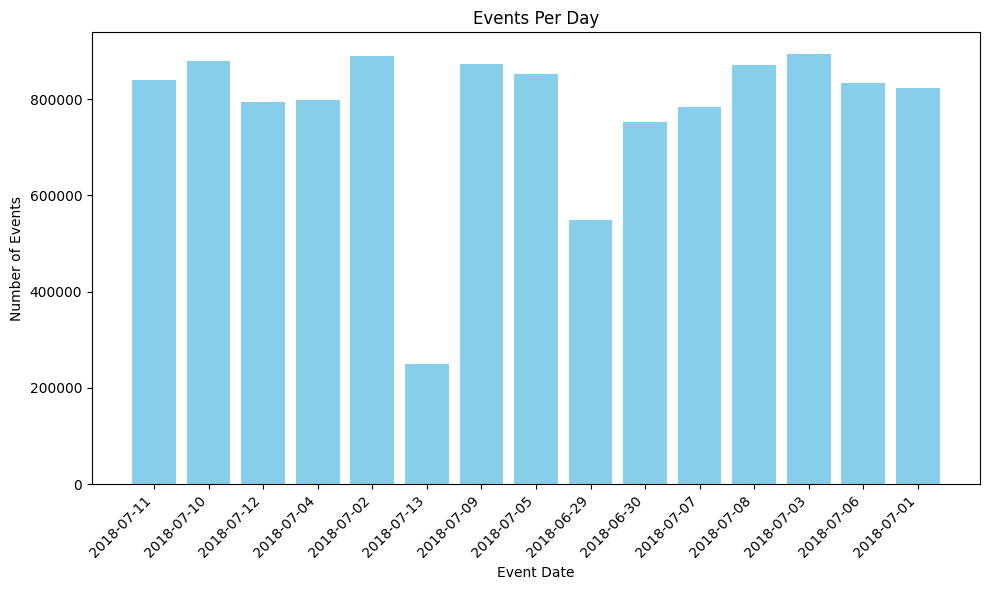

          date  num_events
0   2018-07-11      840069
1   2018-07-10      879483
2   2018-07-12      795112
3   2018-07-04      798557
4   2018-07-02      890146
5   2018-07-13      250672
6   2018-07-09      873487
7   2018-07-05      853602
8   2018-06-29      548479
9   2018-06-30      753423
10  2018-07-07      783265
11  2018-07-08      872008
12  2018-07-03      894514
13  2018-07-06      833722
14  2018-07-01      823685


In [11]:
all_days_df = all_days_with_event_counts(df)

print(all_days_df)

### `Events in Weekdays vs Weekends`
The next summary statistics is the number of events that occured during the week vs the weekend. This is achienved using spark sqls `day of week` function.

  day_type  num_events
0  Weekday     8520663
1  Weekend     3169561


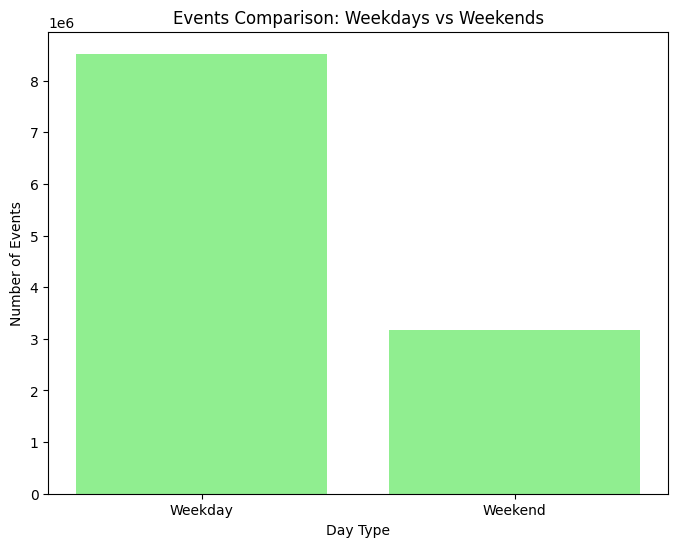

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, when, count

def events_weekdays_vs_weekends(df):
    """
    Compare the number of events on weekdays versus weekends using SparkSQL.

    :param df: Spark DataFrame with an 'event_date' column
    :return: A Pandas DataFrame with events count for weekdays and weekends
    """

    # Add a new column for the day of the week (1 = Monday, 7 = Sunday)
    df = df.withColumn("day_of_week", dayofweek(col("date")))

    # Classify days as Weekday (1-5) or Weekend (6-7)
    df = df.withColumn(
        "day_type",
        when(col("day_of_week").between(1, 5), "Weekday").otherwise("Weekend")
    )

    # Group by day_type (Weekday or Weekend) and count the number of events
    events_by_day_type = df.groupBy("day_type").agg(count("*").alias("num_events"))

    # Convert the result to a Pandas DataFrame
    events_by_day_type_df = events_by_day_type.toPandas()

    # Display the results
    print(events_by_day_type_df)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.bar(events_by_day_type_df['day_type'], events_by_day_type_df['num_events'], color='lightgreen')
    plt.xlabel('Day Type')
    plt.ylabel('Number of Events')
    plt.title('Events Comparison: Weekdays vs Weekends')
    plt.show()

    return events_by_day_type_df

events_comparison_df = events_weekdays_vs_weekends(df)

### `Events per day of week`
This is also another demonstration of how to take advantage of spark sql. Days of the week are mapped with the actual name after using spark sql `day of the week function`.

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofweek, count

def events_per_day_of_week(df):
    """
    Compare the number of events for each day of the week (Monday through Sunday).

    :param df: Spark DataFrame with an 'event_date' column
    :return: A Pandas DataFrame with events count for each day of the week
    """
    # Extract the day of the week (1 = Monday, 7 = Sunday)
    df = df.withColumn("day_of_week", dayofweek(col("date")))

    # Map the day_of_week to actual day names (1 = Monday, 7 = Sunday)
    days_of_week_map = {
        1: "Monday", 2: "Tuesday", 3: "Wednesday",
        4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"
    }

    df = df.withColumn("day_name", when(col("day_of_week") == 1, "Monday")
                              .when(col("day_of_week") == 2, "Tuesday")
                              .when(col("day_of_week") == 3, "Wednesday")
                              .when(col("day_of_week") == 4, "Thursday")
                              .when(col("day_of_week") == 5, "Friday")
                              .when(col("day_of_week") == 6, "Saturday")
                              .otherwise("Sunday"))

    # Group by day_name and count the number of events for each day
    events_by_day = df.groupBy("day_name").agg(count("*").alias("num_events"))

    events_by_day_df = events_by_day.toPandas()

    # Sort the DataFrame to display the days in order (Monday to Sunday)
    events_by_day_df["day_name"] = pd.Categorical(events_by_day_df["day_name"],
                                                   categories=["Monday", "Tuesday", "Wednesday",
                                                              "Thursday", "Friday", "Saturday", "Sunday"],
                                                   ordered=True)
    events_by_day_df = events_by_day_df.sort_values("day_name")

    return events_by_day_df

events_per_day = events_per_day_of_week(df)
print(events_per_day)

    day_name  num_events
5     Monday     1695693
3    Tuesday     1763633
2  Wednesday     1773997
6   Thursday     1638626
4     Friday     1648714
1   Saturday     1632873
0     Sunday     1536688


## Task 3: Individual User Mobility Statistics
`Radius of Gyration`: The radius of gyration is a measure of the "spread" or "dispersion" of a person's locations around the average location. It quantifies how far, on average, a person’s position deviates from the average location.


*   A small radius of gyration indicates that the person tends to stay near the average location, implying less variability in their movement.
*   A larger radius of gyration indicates that the person’s locations are more spread out from the average location, suggesting more extensive movement or higher variability.

The radius of gyration is implemented using a pandas users defined function which is a lot faster that converting the spark dataframe to pandas before doing the computation.

The output of the individual user attributes are then saved as a csv file.


In [14]:
from pyspark.sql.functions import col, countDistinct, collect_list, avg
from pyspark.sql.types import DoubleType
import numpy as np
import pandas as pd

def generate_basic_user_attributes_with_spark(dfu, output_csv, misc_params, num_events_threshold=None):
    """
    Generate basic user mobility attributes using Spark and save the results to a CSV file.

    :param dfu: Spark DataFrame with user mobility data.
    :param output_csv: Path to save the resulting CSV file.
    :param misc_params: Dictionary containing column names and parameters.
    :param num_events_threshold: Minimum number of events required to process a user.
    :return: Spark DataFrame with user mobility attributes.
    """
    if not dfu.is_cached:
        dfu.cache()

    # Extract column names and parameters from misc_params
    user_id_col = misc_params["userid"]
    lat_col = misc_params["y"]
    lon_col = misc_params["x"]
    datetime_col = misc_params["datetime_col"]
    min_unique_locs = misc_params["min_unique_locs"]

    # Step 1: Calculate unique locations and radius of gyration per day
    daily_mobility = (
        dfu.groupBy(user_id_col, "date")
        .agg(
            countDistinct(lat_col, lon_col).alias("unique_locs"),
            collect_list(lat_col).alias("lat_list"),
            collect_list(lon_col).alias("lon_list"),
        )
    )

    # Define UDF for radius of gyration
    def calculate_radius_of_gyration(lat_list, lon_list):
        if len(lat_list) <= 1:
            return 0.0
        coords = np.array(list(zip(lat_list, lon_list)))
        centroid = coords.mean(axis=0)
        distances = np.sqrt(np.sum((coords - centroid) ** 2, axis=1))
        return np.sqrt(np.mean(distances ** 2))

    from pyspark.sql.functions import pandas_udf
    @pandas_udf(DoubleType())
    def radius_of_gyration_udf(lat_list, lon_list):
        return pd.Series(
            [calculate_radius_of_gyration(lat, lon) for lat, lon in zip(lat_list, lon_list)]
        )

    # Add radius of gyration column
    daily_mobility = daily_mobility.withColumn(
        "radius_of_gyration", radius_of_gyration_udf(col("lat_list"), col("lon_list"))
    )

    # Aggregate by user to compute overall metrics
    user_mobility = (
        daily_mobility.groupBy(user_id_col)
        .agg(
            countDistinct("date").alias("active_days"),
            avg("unique_locs").alias("avg_unique_locs_per_day"),
            avg("radius_of_gyration").alias("avg_radius_of_gyration"),
        )
    )

    # Apply the threshold filter
    if num_events_threshold:
        user_mobility = user_mobility.filter(col("active_days") >= num_events_threshold)

    # Save the Output to CSV
    user_mobility.write.csv(output_csv, header=True, mode="overwrite")
    print(f"User mobility attributes saved to: {output_csv}")

    return user_mobility

In [15]:
output_csv = "user_mobility_attributes.csv"
user_mobility_df = generate_basic_user_attributes_with_spark(
    df, output_csv, MISC_PROCESSING_PARAMS, num_events_threshold=2
)

User mobility attributes saved to: user_mobility_attributes.csv


### Mean Radius of Gyration vs Average Locations per day

This function utilizes the `corr` function in sparksql to calculate the correlation between average radius of gyration per day and the average number of locations per user.
From the resulting plot, it is clear that the two metrices are corelated. Most of the population at study have an average of less than 10 unique locations with an average radius of gyration of between 0.0 and 0.2. From this dataset it is clear that call detail records can be used for mobility analysis.

In [16]:
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt
import seaborn as sns

def explore_correlation_between_metrics(user_mobility_df, output_plot="correlation_plot.png"):
    """
    Explore the correlation between avg_Rg and avg_locs_per_day.

    :param user_mobility_df: Spark DataFrame containing 'avg_radius_of_gyration' and 'avg_unique_locs_per_day'.
    :param output_plot: Path to save the correlation plot.
    :return: Correlation coefficient.
    """
    if not user_mobility_df.is_cached:
        user_mobility_df.cache()

    # Calculate correlation using Spark
    correlation = user_mobility_df.select(
        corr("avg_radius_of_gyration", "avg_unique_locs_per_day").alias("correlation")
    ).collect()[0]["correlation"]

    print(f"Correlation coefficient between avg_Rg and avg_locs_per_day: {correlation:.4f}")

    # Convert Spark DataFrame to Pandas for visualization
    pdf = user_mobility_df.select("avg_radius_of_gyration", "avg_unique_locs_per_day").toPandas()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pdf, x="avg_radius_of_gyration", y="avg_unique_locs_per_day")
    sns.regplot(
        data=pdf,
        x="avg_radius_of_gyration",
        y="avg_unique_locs_per_day",
        scatter=False,
        color="red",
    )
    plt.title("Correlation Between Avg Radius of Gyration and Avg Locations Per Day")
    plt.xlabel("Average Radius of Gyration (avg_Rg)")
    plt.ylabel("Average Locations Per Day (avg_locs_per_day)")
    plt.grid()
    plt.savefig(output_plot)
    plt.show()

    print(f"Correlation plot saved to: {output_plot}")

    return correlation


Correlation coefficient between avg_Rg and avg_locs_per_day: 0.3235


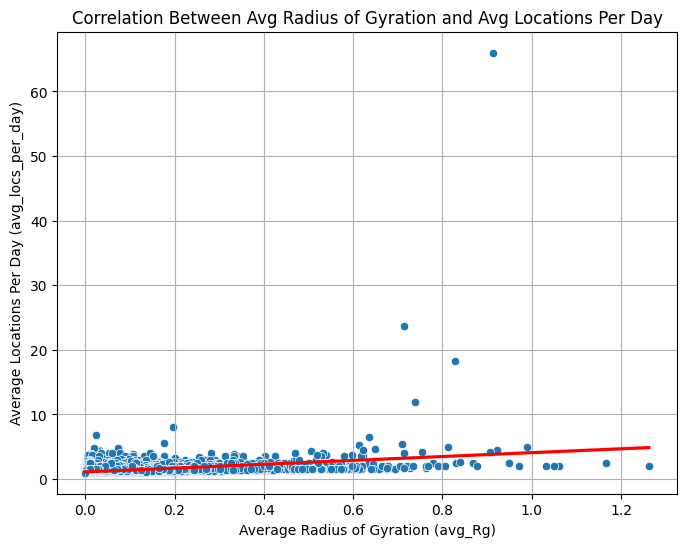

Correlation plot saved to: correlation_plot.png


In [17]:
# Assuming `user_mobility_df` contains the required columns
correlation = explore_correlation_between_metrics(user_mobility_df, output_plot="correlation_plot.png")

## Task 4: Challenges and Strategies
**Challenges**


*   Size of the dataset: The size of the dataset required efficient processing techniques and memory management.
*   Location metrix: Calculating radius of gyration (Rg) and average unique locations per day required specific logic logic.

**Strategies**

Strategies such as repartitioning the data ensured balanced load distribution across partitions, while persisting intermediate results (`persist()` and `cache()`) avoided redundant computations during repeated access. During debugging, sampling smaller subsets of the data helped speed up testing without compromising scalability for full-scale processing. Additionally, optimizing complex metric calculations, such as the radius of gyration, involved leveraging built-in Spark SQL functions and efficient vectorized operations through Pandas UDFs. Grouping data early in the workflow reduced redundant processing, and unnecessary data format conversions (e.g., from Spark to Pandas) to maintain efficiency for the large dataset. These combined strategies ensured that both large-scale data handling and computationally intensive tasks were addressed effectively.


